In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 23.7 MB/s eta 0:00:00


In [3]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.calibrate import calibrate_model
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.q_labels_matching import enrich_q_labels_trend_one_side, soft_signal_labels_gaussian
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.visualisation import plot_enriched_actions_one_side
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.residual_lstm import build_stacked_residual_lstm
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.optuna_tuner import optimize_hyperparameters
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *

# from scr.check_data import prepare_time_series
# from scr.calibrate import calibrate_model
# from scr.q_labels_matching import enrich_q_labels_trend_one_side
# from scr.visualisation import plot_enriched_actions_one_side
# from scr.dataset_builder import DatasetBuilderForYourColumns
# from scr.residual_lstm import build_stacked_residual_lstm
# from scr.train_eval import fit_model, plot_history_curves, evaluate_dataset, confusion_and_f1_on_dataset, materialize_metrics, predict_logits_dataset
# from scr.backtest_env import BacktestEnv, EnvConfig, run_backtest_with_logits
# from scr.optuna_tuner import optimize_hyperparameters
# from scr.indicators import *


In [4]:
# @title Параметры
# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"
START = "2024-01-20"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps
EMA_FAST_PERIOD = 300
EMA_SLOW_PERIOD = 350
SPLITS = (0.8, 0.15, 0.05)

SEQ_LEN = 3
BATCH_SIZE = 512
UNITS_PER_LAYER = [32, 32]
DROPOUT = 0.5
EPOCHS = 10
LR = 1e-4
GRAD_CLIP_NORM = 1.0
EARLY_STOPPING_PATIENCE = 20
LR_MODE = "onecycle"
ONECYCLE_MAX_LR = 5e-3
ONECYCLE_PCT_START = 0.5
LR_RESTART_PATIENCE = 4
LR_RESTART_SHRINK = 0.5
BEST_PATH = "best_lstm.weights.h5"

FEE = 0.0002
SLIPPAGE = 0.0001
T = None

FEATURES = [
    "Open", "High", "Low", "Close", "Volume",
    "EMA_fast_raw", "EMA_slow_raw", "EMA_fast", "EMA_slow",
    "SMA_14", "ADX_14", "ATR_14", "RSI_14",
    "MACD", "MACD_signal", "MACD_hist",
    "STOCH_K", "STOCH_D",
    "BOLL_MID", "BOLL_UP", "BOLL_DN",
    "OBV", "CCI_20", "WILLR_14", "MFI_14", "ROC_12", "VWAP_20",
]
ACCOUNT_F = [
    "Unreal_PnL", "Flat_Steps", "Hold_Steps", "Drawdown", "Pos",
]


In [5]:
# Load and check data
raw_df = joblib.load(PATH_TO_DATA).loc[START:END]
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL)
print(f"From {df.index[0]} to {df.index[-1]}")


From 2024-01-20 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [6]:
# Add indicators
close = df['Close'].to_numpy(np.float64)
high = df['High'].to_numpy(np.float64)
low = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

df['EMA_fast_raw'] = ema_numba(close, EMA_FAST_PERIOD)
df['EMA_slow_raw'] = ema_numba(close, EMA_SLOW_PERIOD)
df['EMA_fast'] = ema_numba_safe(close, EMA_FAST_PERIOD)
df['EMA_slow'] = ema_numba_safe(close, EMA_SLOW_PERIOD)
df['SMA_14'] = sma_numba(close, 14)
df['ADX_14'] = adx_numba(high, low, close, 14)
df['ATR_14'] = atr_numba(high, low, close, 14)
df['RSI_14'] = rsi_numba(close, 14)
macd, macd_signal, macd_hist = macd_numba(close, 12, 26, 9)
df['MACD'] = macd
df['MACD_signal'] = macd_signal
df['MACD_hist'] = macd_hist
stoch_k, stoch_d = stoch_numba(high, low, close, 14, 3)
df['STOCH_K'] = stoch_k
df['STOCH_D'] = stoch_d
boll_mid, boll_up, boll_dn = bollinger_numba(close, 20, 2.0)
df['BOLL_MID'] = boll_mid
df['BOLL_UP'] = boll_up
df['BOLL_DN'] = boll_dn
df['OBV'] = obv_numba(close, volume)
df['CCI_20'] = cci_numba(high, low, close, 20)
df['WILLR_14'] = williams_r_numba(high, low, close, 14)
df['MFI_14'] = mfi_numba(high, low, close, volume, 14)
df['ROC_12'] = roc_numba(close, 12)
df['VWAP_20'] = vwap_numba(high, low, close, volume, 20)
piv = zigzag_pivots_highlow_numba(high, low, close, 0.05, -0.05, 3, 1)
df['Signal_Rule'] = piv
# df['Pivots_expanded'] = expand_pivots(piv, 2)


In [ ]:
# Добавляем сигнал референс стратегии
buy_sig  = (df['EMA_fast'] > df['EMA_slow']) & (df['Close'] > df['EMA_fast']) & (df['ADX_14'] > 20)
sell_sig = (df['EMA_fast'] < df['EMA_slow']) & (df['Close'] < df['EMA_fast']) & (df['ADX_14'] > 20)
df['Signal_Rule'] = np.where(buy_sig, 1, np.where(sell_sig, -1, 0)).astype(np.int8)


In [7]:
# Q-labels
# df = enrich_q_labels_trend_one_side(
#     df,

#     # mode='tdlambda',
#     # H_max = 300,
#     # lam = 0.98,

#     mode='horizon',
#     H_max = 120,

#     # mode='exit',

#     fee=FEE,
#     slippage=SLIPPAGE,
#     use_mae_penalty=False,
#     mae_lambda=10
# )

# Soft gaussian labels
df = soft_signal_labels_gaussian(
    df,
    side_long = True,
    blur_window=1000,
    blur_sigma=100,
    mae_lambda=5,

)
print(df[2500:2600].to_string())


         timestamp     Open     High      Low    Close     Volume  EMA_fast_raw  EMA_slow_raw  EMA_fast  EMA_slow    SMA_14     ADX_14    ATR_14     RSI_14          MACD   MACD_signal     MACD_hist     STOCH_K    STOCH_D  BOLL_MID   BOLL_UP   BOLL_DN         OBV      CCI_20    WILLR_14     MFI_14    ROC_12   VWAP_20  Signal_Rule  Unreal_PnL  Flat_Steps  Hold_Steps  Drawdown  Pos    A_Open  A_Close  A_Hold    A_Wait
2500  1.705859e+12  0.08668  0.08674  0.08666  0.08674   229869.0      0.086972      0.086967  0.086972  0.086967  0.086771  23.091865  0.000079  52.216504  2.695511e-05  5.305780e-05 -2.610270e-05   34.782609  18.538647  0.086780  0.086902  0.086657  84947625.0  -83.601286  -65.217391  58.264024 -0.161142  0.086782            0         0.0       1.099         0.0       0.0    0  0.019421      0.0     0.0  0.980579
2501  1.705859e+12  0.08677  0.08680  0.08676  0.08677   258858.0      0.086971      0.086966  0.086971  0.086966  0.086766  22.187457  0.000078  54.461747  2.707

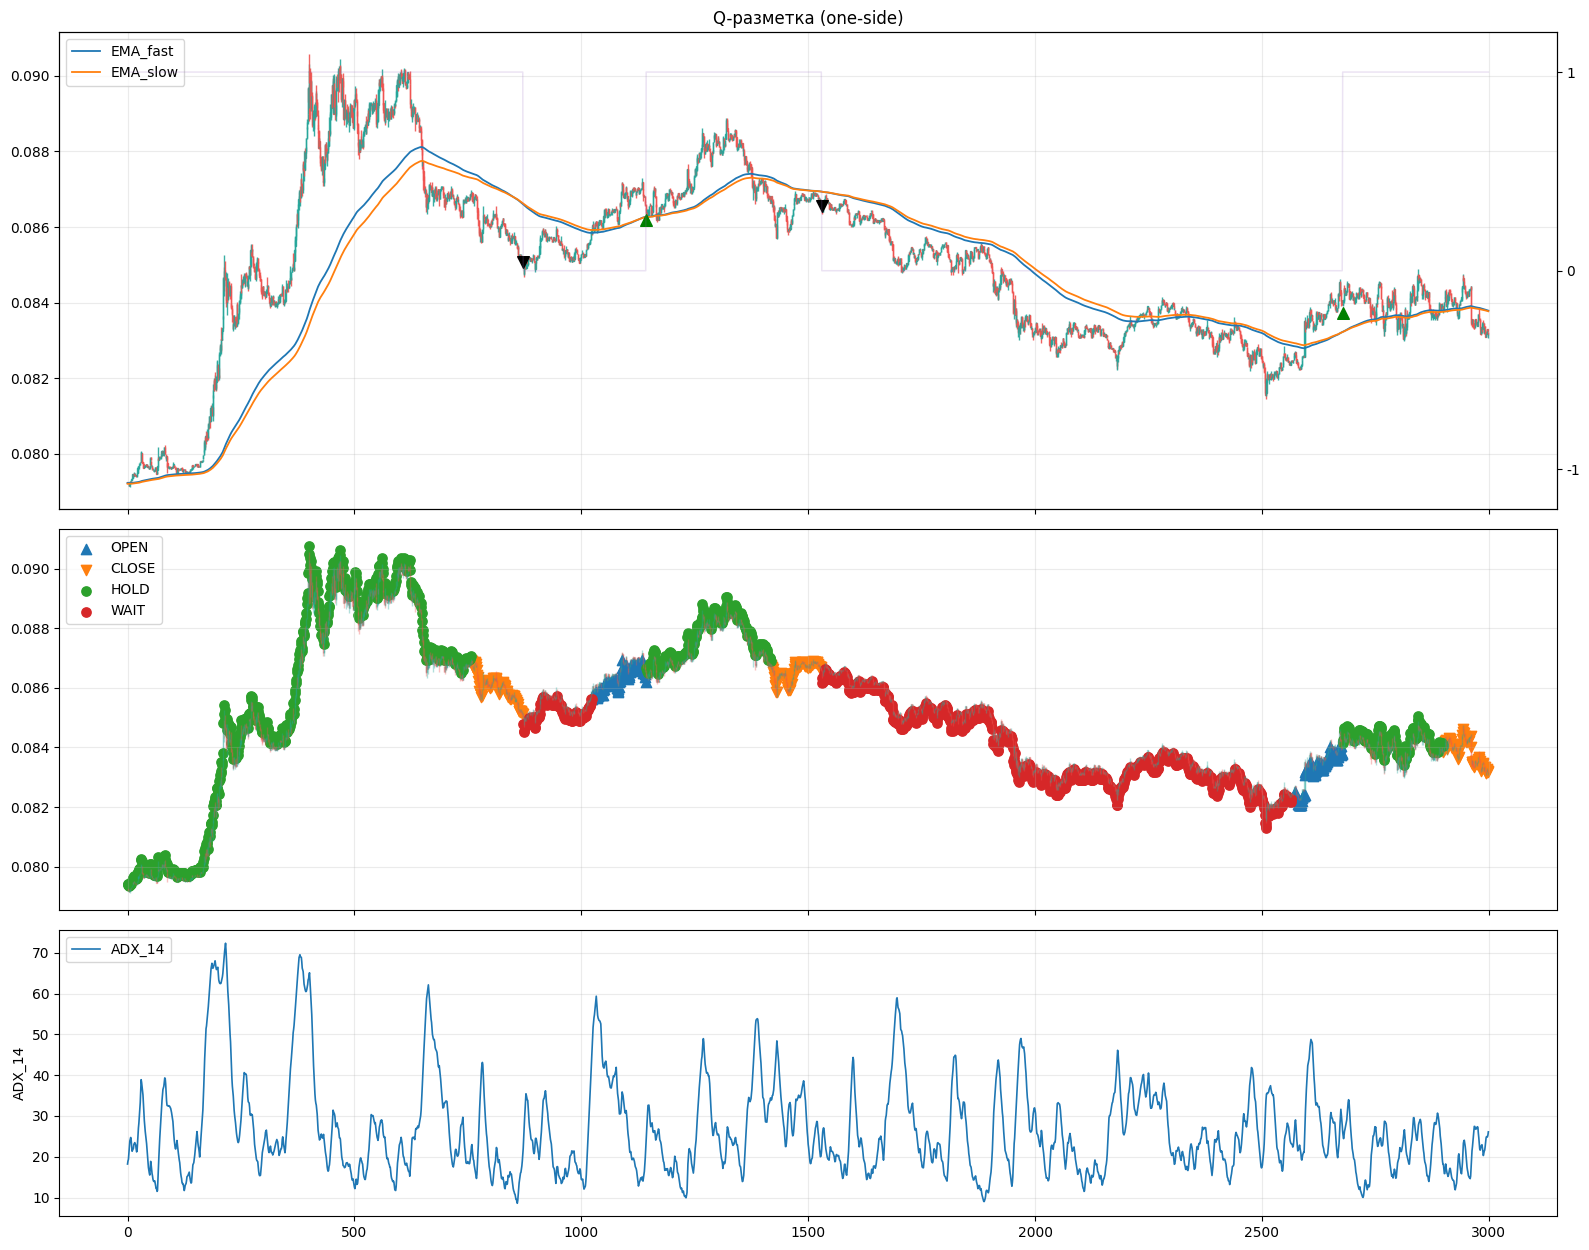

In [ ]:
# Visualisation
plot_enriched_actions_one_side(
    df,
    start=1000,
    end=4000,
    indicators_price={
        'EMA_fast':df['EMA_fast'],
        'EMA_slow':df['EMA_slow'],
        },
    indicators_panels={
        'ADX_14':df['ADX_14'],
    }
)


In [8]:
# @title Нормализация и нарезка данных
enriched = df
builder = DatasetBuilderForYourColumns(
    seq_len=SEQ_LEN, norm="minmax",
    labels_from="a", # change to "q" if use q-labels
    tau=1, r_mode="oracle",
    splits=SPLITS,
    batch_size=BATCH_SIZE,
    sw_mode="ClassBalance",
    feature_cols = FEATURES,
    account_cols = ACCOUNT_F,
)
splits = builder.fit_transform(enriched, return_indices=True)
train_ds, val_ds, test_ds = builder.as_tf_datasets(splits)
test_idx = splits["test"][-1]


In [ ]:
xb, play_off = next(iter(train_ds.take(1)))
Y,_,_,_,_ = play_off
Y

<tf.Tensor: shape=(512, 4), dtype=float32, numpy=
array([[0.8318881 , 0.        , 0.        , 0.16811194],
       [0.00123533, 0.        , 0.        , 0.9987647 ],
       [0.        , 0.1965261 , 0.8034739 , 0.        ],
       ...,
       [0.        , 0.21148619, 0.78851384, 0.        ],
       [0.00644411, 0.        , 0.        , 0.9935559 ],
       [0.00144209, 0.        , 0.        , 0.9985579 ]], dtype=float32)>

In [ ]:
# @title Оптимизация гиперпараметров

xb, _ = next(iter(train_ds.take(1)))
feature_dim = xb.shape[-1]
best_params = optimize_hyperparameters(
    train_ds,
    val_ds,
    seq_len=SEQ_LEN,
    feature_dim=feature_dim,
    n_trials=10,
    epochs=5,
)
UNITS_PER_LAYER = best_params['units_per_layer']
DROPOUT = best_params['dropout']
LR = best_params['lr']


Epoch 01 | train: loss 0.6019, acc 0.6659, ER 0.000000 | val: loss 0.4124, acc 0.8512, macroF1 0.2727, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 02 | train: loss 0.5684, acc 0.6971, ER 0.000000 | val: loss 0.4158, acc 0.8532, macroF1 0.2774, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 03 | train: loss 0.5551, acc 0.7109, ER 0.000000 | val: loss 0.4096, acc 0.8527, macroF1 0.2805, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 04 | train: loss 0.5511, acc 0.7162, ER 0.000000 | val: loss 0.4208, acc 0.8506, macroF1 0.2828, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 05 | train: loss 0.5482, acc 0.7199, ER 0.000000 | val: loss 0.4141, acc 0.8489, macroF1 0.2833, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 06 | train: loss 0.5463, acc 0.7209, ER 0.000000 | val: loss 0.4184, acc 0.8464, macroF1 0.2837, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 07 | train: loss 0.5458, acc 0.7205, ER 0.000000 | val: loss 0.4037, acc 0.8520, macroF1 0.2807, ER 0.000000, ICp 0.0000, ICs 1.0000
Epoch 08 | train: loss 0.54

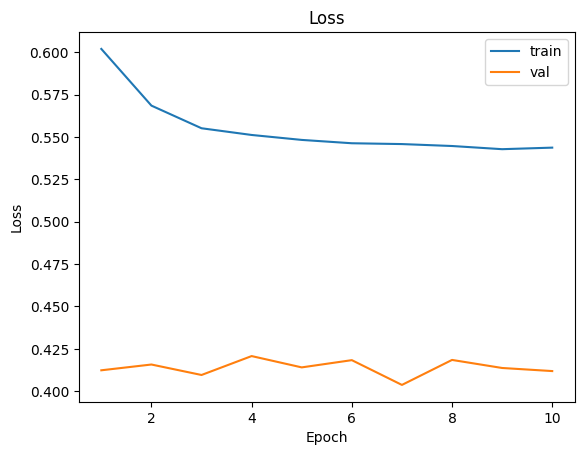

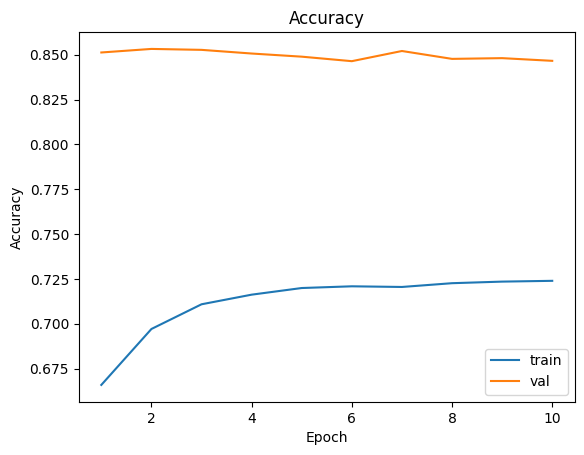

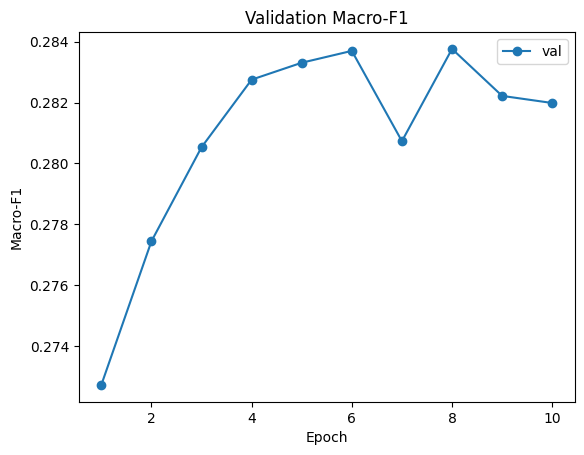

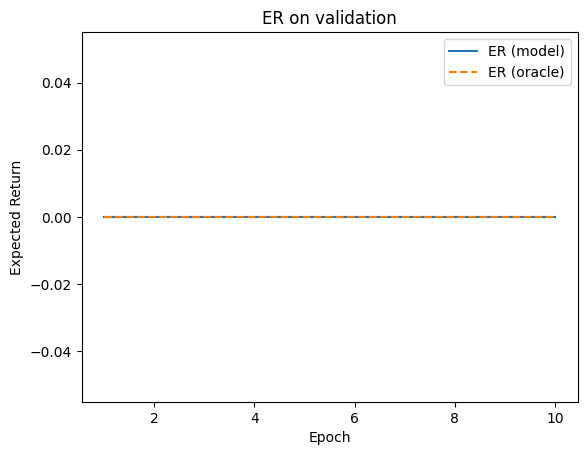

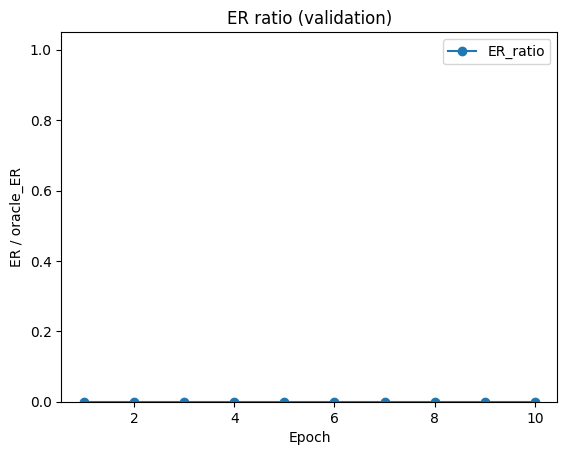

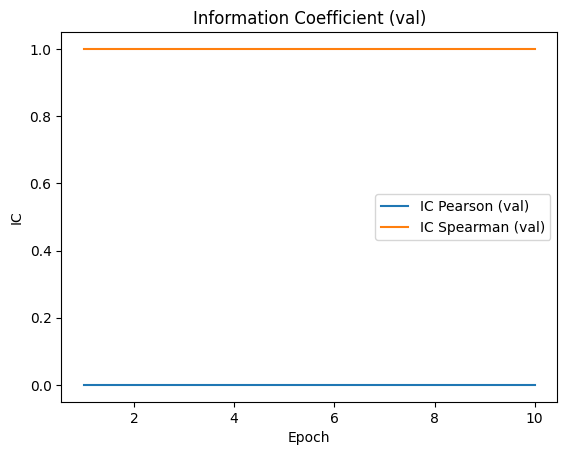

In [9]:
# @title Обучение модели
(xb, accb), _ = next(iter(train_ds.take(1)))
model = build_stacked_residual_lstm(seq_len=xb.shape[1],
                                    feature_dim=xb.shape[-1],
                                    account_dim=accb.shape[-1],
                                    units_per_layer=UNITS_PER_LAYER,
                                    dropout=DROPOUT)

history = fit_model(
    model,
    train_ds,
    val_ds,
    epochs=EPOCHS,
    steps_per_epoch=None,
    lr=LR,
    grad_clip_norm=GRAD_CLIP_NORM,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    lr_mode=LR_MODE,
    onecycle_max_lr=ONECYCLE_MAX_LR,
    onecycle_pct_start=ONECYCLE_PCT_START,
    lr_restart_patience=LR_RESTART_PATIENCE,
    lr_restart_shrink=LR_RESTART_SHRINK,
    best_path=BEST_PATH,
)

plot_history_curves(history)


In [ ]:
# Loading weights
model.load_weights(BEST_PATH)

In [10]:
# 3) оценка на тесте
test_metrics = evaluate_dataset(model, test_ds)
print("TEST METRICS:")
for k,v in  materialize_metrics(test_metrics).items():
  print(f"{k}:{v}")


TEST METRICS:
loss:0.48258042335510254
acc:0.806954026222229
macro_f1:0.2969323694705963
f1_per_class:[0.018218539655208588, 0.08771555125713348, 0.5573431253433228, 0.5244522094726562]
exp_return:0.0
oracle_ER:0.0
ER_ratio:0.0
IC_pearson:0.0
IC_spearman:1.0


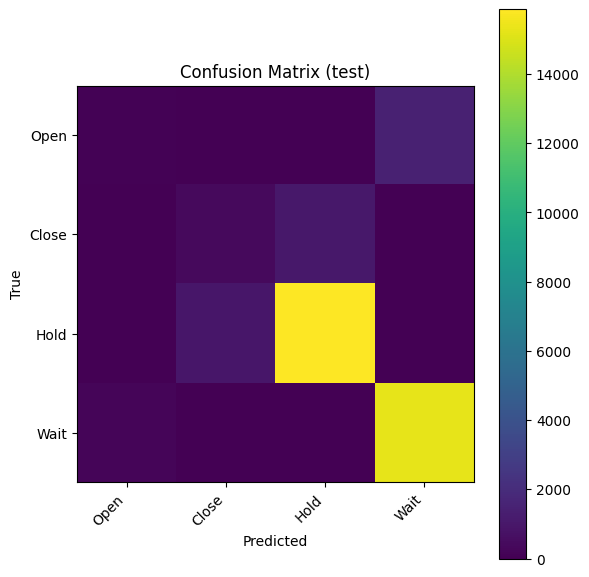

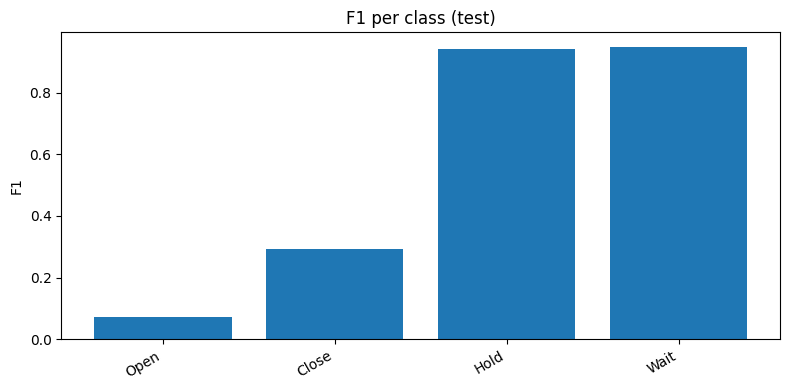

In [11]:
# 4) конфьюжн-матрица и F1 per class на тесте
cm_test, f1_test = confusion_and_f1_on_dataset(model, test_ds)

In [ ]:
# @title Калибровка модели
calib_info = calibrate_model(model, val_ds, per_class=True, init_T=1.0, plot=True)
T = calib_info['T']
print("Температуры: ", T)


Метрики референс стратегии:
Equity: 1.6202
Realized PnL: 1.6115
Closed trades: 13
Win rate: 100.00%
Avg PnL per trade: 0.1241
Profit factor: inf
Max drawdown: 0.5401
Sharpe ratio: 7.9773


100%|██████████| 35277/35277 [17:32<00:00, 33.52it/s]



Метрики модели:
Equity: -0.0420
Realized PnL: -0.0420
Closed trades: 183
Win rate: 51.91%
Avg PnL per trade: -0.0001
Profit factor: 0.9022
Max drawdown: 5.1795
Sharpe ratio: -0.8931


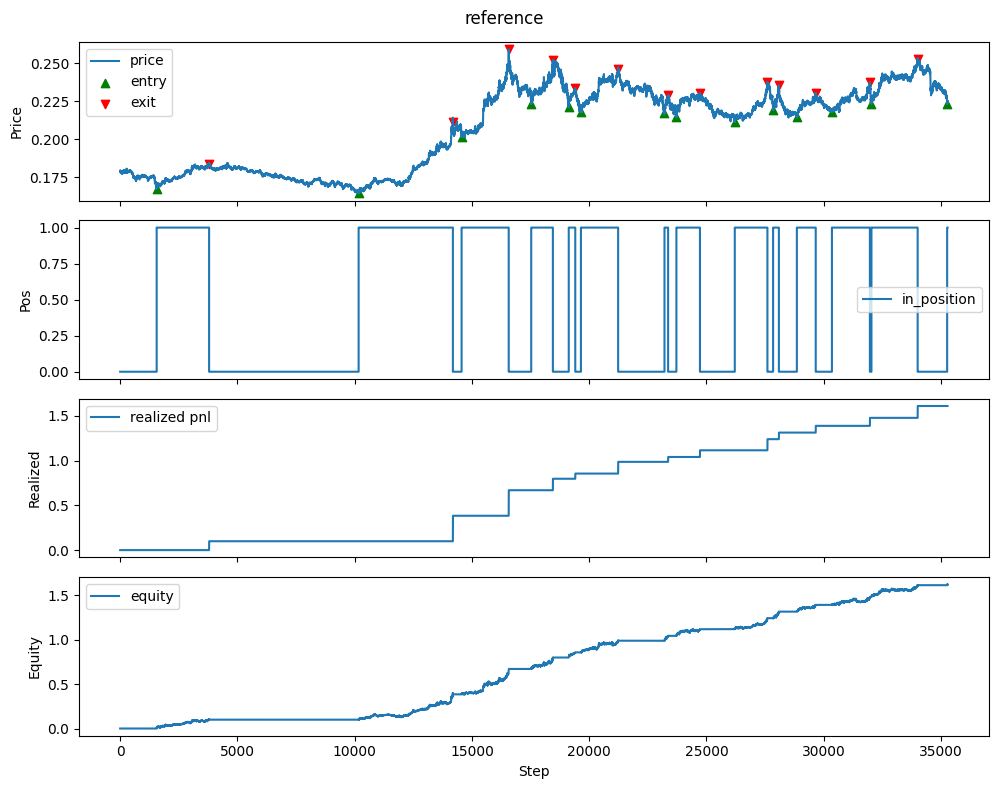

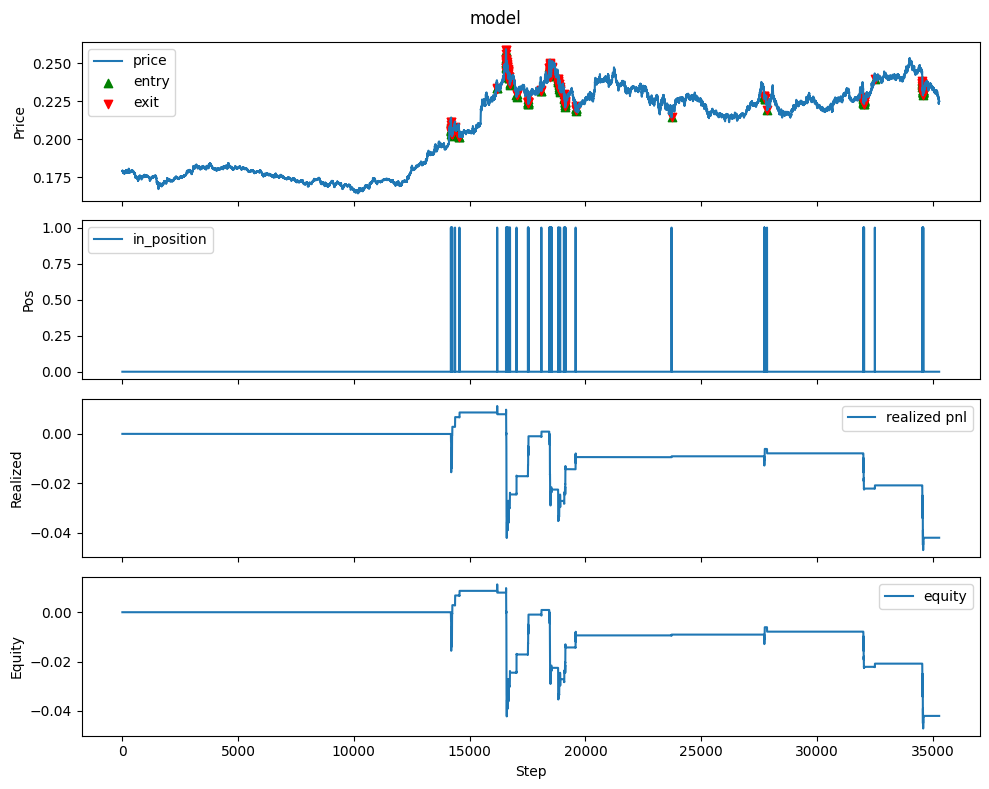

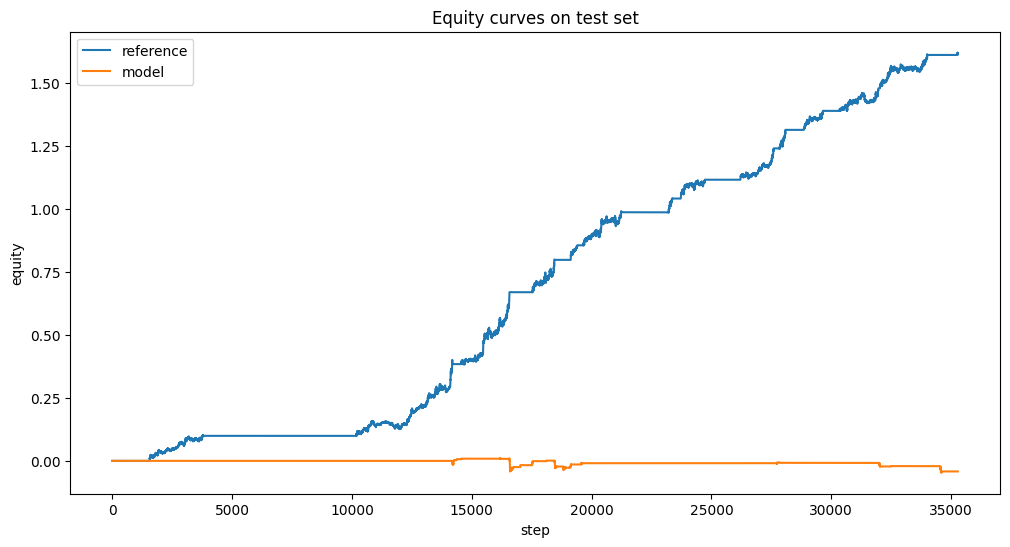

In [12]:
# @title Запуск бэктестов: референс стратегия, модель, учитель

def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['Signal_Rule'].iloc[:-1]:
        pos = env.position
        if sig == 1:
            action = 0 # OPEN
        elif sig == -1:
            action = 1 # CLOSE
        else:
            action = 2 if pos == 1 else 3 # HOLD or WAIT
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.0002,         # без комиссии
    spread=0.0001,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

start, end = int(test_idx[0]), int(test_idx[-1])
df_bt = enriched.iloc[start:end+2].copy()

env_ref = BacktestEnv(df_bt, feature_cols=['EMA_fast', 'EMA_slow'], cfg=LONG_CONFIG, price_col='Open')
sim_ref = run_backtest(df_bt, env_ref)
sim_ref.plot("reference")
print('Метрики референс стратегии:')
print(sim_ref.metrics_report())

def model_infer(inputs, training=False):
    logits = model(inputs, training=False)
    return logits / T if T is not None else logits

env_model = run_backtest_with_logits(
    enriched,
    model_infer,
    feature_stats=builder.stats_features,
    seq_len=SEQ_LEN,
    start=start,
    feature_cols=builder.feature_names,
    price_col='Open',
    cfg=LONG_CONFIG,
    state_stats=builder.stats_account,
)
env_model.plot("model")
print('\nМетрики модели:')
print(env_model.metrics_report())

# env_teacher = run_backtest_with_logits(
#     enriched,
#     teacher_model,
#     feature_stats=builder.stats_features,
#     seq_len=SEQ_LEN,
#     start=start,
#     feature_cols=builder.feature_names,
#     price_col='Open',
#     cfg=LONG_CONFIG,
#    state_stats=builder.stats_account,
# )
# env_teacher.plot("teacher")
# print('\nМетрики учителя:')
# print(env_teacher.metrics_report())

log_ref = sim_ref.logs()
log_model = env_model.logs()
# log_teacher = env_teacher.logs()
plt.figure(figsize=(12,6))
plt.plot(log_ref['equity'], label='reference')
plt.plot(log_model['equity'], label='model')
# plt.plot(log_teacher['equity'], label='teacher')
plt.legend()
plt.title('Equity curves on test set')
plt.xlabel('step')
plt.ylabel('equity')
plt.show()
